In [8]:
import os
import torch
import pandas as pd
import scanpy as sc
from SPHERE.preprocess import *
from SPHERE.SPHERE import *
from SPHERE.utils import *
import numpy as np
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
random_seed = 2022
fix_seed(random_seed)

In [ ]:
datasets = ['./s1.h5ad',
            './s2.h5ad',]
adata_list = [sc.read_h5ad(dataset) if isinstance(dataset, str) else dataset for dataset in datasets]
slice_name_list = ['S1', 'S2']

import anndata as ad
adata = ad.concat(adata_list, label="slice_name", keys=slice_name_list)
print(adata)

AnnData object with n_obs × n_vars = 4926 × 44140
    obs: 'label', 'slice_name'
    obsm: 'spatial', 'spatial_rot90'


In [10]:
adata.X[adata.X.nonzero()] = 1
adata.var_names_make_unique()
sc.pp.filter_genes(adata, min_cells=int(0.01 * adata.shape[0]))
pca_feat(adata, n_comps=200)
adata.obsm['feat'] = adata.obsm['X_pca'].copy()

In [11]:
adata_st = construct_neighbor_graph_inte(adata, slice_name_list,loc_neighbors=12,gene_neighbors=10)

In [12]:
batch_categories = np.unique(adata.obs['slice_name'])
batch_to_index = {batch: idx for idx, batch in enumerate(batch_categories)}
batch_indices = adata.obs['slice_name'].map(batch_to_index).values
num_batches = len(batch_categories)
batch_labels = np.eye(num_batches)[batch_indices]

In [13]:
model = SPHERE(adata, device=device, learning_rate=0.001, epochs=1000, dim_hid=64, 
               integrate=True, batch_label=batch_labels,slice_name_list = slice_name_list, pretrain=False,lambda_fea_recon=0.5,lambda_spa_recon=1,
               lambda_recon=15,lambda_con=6,lambda_align=8,lambda_latent=5)

In [14]:
output = model.train_inte()
adata.obsm['latent'] = output['latent']
adata.obsm['latent'] = pca(adata, use_reps='latent', n_comps=20)
sc.pp.neighbors(adata, use_rep='latent', n_neighbors=30)
sc.tl.umap(adata)

100%|██████████| 1000/1000 [00:38<00:00, 25.85it/s]


Model training finished!



/home/yuzhuohan/miniconda3/envs/SPHERE/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
res = search_res(adata, 6, use_rep='latent', method='leiden', start=0.1, end=0.7, increment=0.01) 
sc.tl.leiden(adata, random_state=0, resolution=res)

Searching resolution...
resolution=0.6899999999999997, cluster number=6


In [20]:
adata = sc.read_h5ad('/home/yuzhuohan/workspace/ATAC/our/other_data/thymus/output/thymus_inte1.h5ad')
sc.pp.neighbors(adata, use_rep='latent', n_neighbors=30)
sc.tl.umap(adata)

/home/yuzhuohan/miniconda3/envs/SPHERE/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


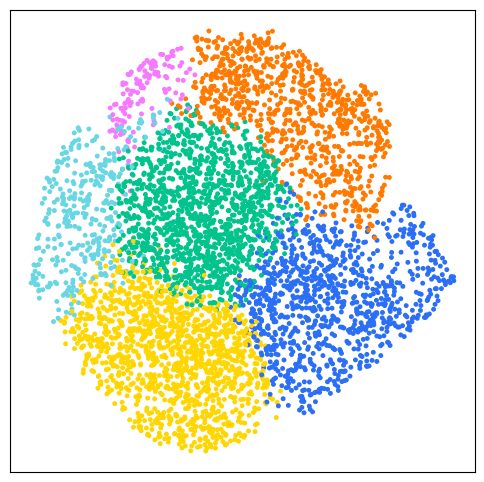

In [ ]:
# domain
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6, 6)
plot_color = [
    "#00C48C",  
    "#FFD600",  
    "#2A6FF5",  
    "#FF7A00",  
    "#68D6E3", 
    "#F67AFF",  
]
fig, ax = plt.subplots()
sc.pl.umap(
    adata, 
    color=["leiden"],
    s=50,
    show=False,
    palette=plot_color,
    legend_loc=None,
    ax=ax
)
ax.set_title("") 
ax.set_xlabel("") 
ax.set_ylabel("")

/home/yuzhuohan/miniconda3/envs/SPHERE/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


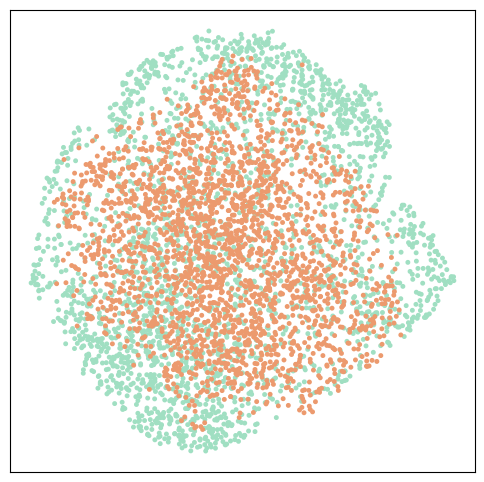

In [ ]:
# batch
plt.rcParams["figure.figsize"] = (6, 6)
plot_color=["#A0DFC2","#EC9A6E","#9FACD5","#DD92BD"]
fig, ax = plt.subplots()
sc.pl.umap(
    adata, 
    color=["slice_name"],
    s=50,
    show=False,
    palette=plot_color,
    legend_loc=None,
    ax=ax
)
ax.set_title("") 
ax.set_xlabel("")  
ax.set_ylabel("")

## S1

/home/yuzhuohan/miniconda3/envs/SPHERE/lib/python3.8/site-packages/scanpy/plotting/_utils.py:432: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/home/yuzhuohan/miniconda3/envs/SPHERE/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Axes: title={'center': 'leiden'}, xlabel='spatial_rot901', ylabel='spatial_rot902'>

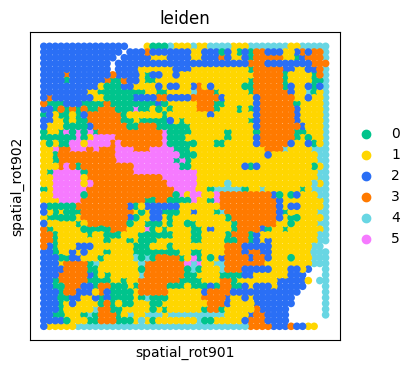

In [23]:
adata_sub = adata[adata.obs['slice_name']==slice_name_list[0]]

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (4, 4)
plot_color = [
    "#00C48C",  
    "#FFD600",  
    "#2A6FF5",  
    "#FF7A00",  
    "#68D6E3", 
    "#F67AFF",  
]
sc.pl.embedding(adata_sub, basis="spatial_rot90",
                color="leiden",
                s=120,
                show=False,
                palette=plot_color)

## S2

/home/yuzhuohan/miniconda3/envs/SPHERE/lib/python3.8/site-packages/scanpy/plotting/_utils.py:432: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/home/yuzhuohan/miniconda3/envs/SPHERE/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Axes: title={'center': 'leiden'}, xlabel='spatial_rot901', ylabel='spatial_rot902'>

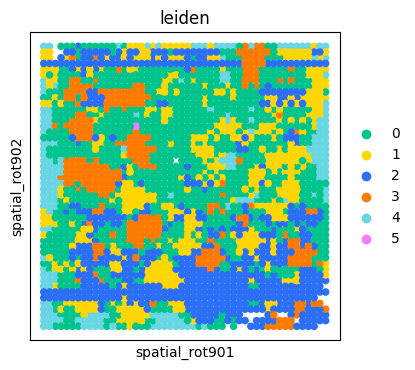

In [24]:
adata_sub = adata[adata.obs['slice_name']==slice_name_list[1]]

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (4, 4)
plot_color = [
    "#00C48C",  
    "#FFD600",  
    "#2A6FF5",  
    "#FF7A00",  
    "#68D6E3", 
    "#F67AFF",  
]
sc.pl.embedding(adata_sub, basis="spatial_rot90",
                color="leiden",
                s=120,
                show=False,
                palette=plot_color)